$\textbf{Linear semi-gradient Sarsa tailored for the reset application}$

The pseudo-code for linear semi-gradient Sarsa algorithm tailored for the reset application can be found in Algorithm 1.

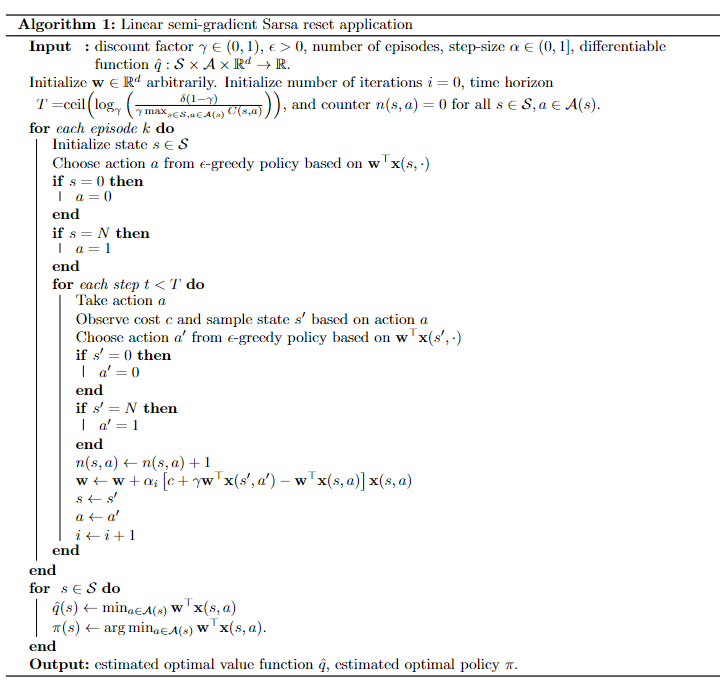

The implementation for this algorithm can be found in the code below.

In [22]:

import numpy as np
import time
import matplotlib.pyplot as plt

def x(s,a,d):
    
    ## tabular case:
    # matrix full of zeros that is one at (s,a)
    feature_matrix = np.zeros([d,2])
    feature_matrix[s,a]=1
    # reshaping the matrix into a vector
    feature_vector=np.reshape(feature_matrix,(2*d,))
    
    ## x(s)=s
    feature_matrix = np.zeros([d,2])
    feature_matrix[s,a]=s
    # reshaping the matrix into a vector
    feature_vector=np.reshape(feature_matrix,(2*d,))
    
    return feature_vector


def linear_semi_gradient_sarsa(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes ,d):
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
    alpha_type = alpha
    
    # in case we want to use one of the three epsilon depending on the episode/iteration 
    # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
    # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
    # epsilon_type = 4: epsilon = 1/(episode nr)
    epsilon_type = epsilon
    
    # size of the state space-1
    N=np.size(P,1)-1
    
    # state space S
    S=np.arange(N+1)
    
    # Initialize Q-values by 0, here the rows correspond to the action and columns to the state
    # i.e., Q is of the form Q[s,a]
    Q=np.zeros([N+1,2])
    
    # setting the Q value for "illegal" actions to infinity
    Q[0,1]=float("inf")
    Q[N,0]=float("inf")
    
    # initialize weights vector w of size d
    w = np.zeros(2*d)
    
    # nr of iterations
    it=0
    
    # preselect time-horizon T
    delta=0.000001 # error margin
    C_0[N]=0 # setting cost "illegal" actions to zero
    C_1[0]=0 # setting cost "illegal" actions to zero
    C=np.array([C_0,C_1])   
    T=round(np.log((delta*(1-gamma))/(C.max()))/np.log(gamma)-1) # time-horizon T
    
    # Q[s,a,iteration number]: array to keep track of the Q-value per iteration
    Q_it=np.zeros([N+1,2,(nrepisodes-1)*T])
    
    # w[s,episode number]: array to keep track of the weights per iteration
    w_it=np.zeros([2*d,(nrepisodes-1)*T])
    
    # n_it[s,a] denotes the number of times (s,a) is visited
    n_it=np.zeros([N+1,2])
    
    # array to keep track of the actions, costs, states, and step-size at each iteration
    a_it = np.zeros((nrepisodes-1)*T)
    r_it = np.zeros((nrepisodes-1)*T)
    s_it = np.zeros((nrepisodes-1)*T)
    alpha_it = np.zeros([N+1,2,(nrepisodes-1)*T])
    
    # loop for each episode
    for e in range(1,nrepisodes):

        
        # randomly selecting and storing initial state
        state =  np.random.randint(0, N+1)
        
        ## select and store an action a_0
        ## epsilon-greedy policy:
        p=np.random.random() # sampling a p in [0,1)
        
        # selecting the epsilon, in case we want a episode/iteration dependent epsilon
        if epsilon_type==2:
        # epsilon = 1/min(episode nr, minimum nr of visits to state s)
           epsilon=1/min(e,max(1,min(n_it[state,:])))
        elif epsilon_type==3:
        # epsilon = 1/(minimum nr of visits to state s)
           epsilon=1/max(1,min(n_it[state,:]))
        elif epsilon_type==4:
        # epsilon = 1/episode nr
           epsilon = 1/e
        
        # with probability eps: random policy
        if p<epsilon: 
            action = np.random.randint(0, 2) 
        # with probability 1-eps: greedy policy
        else: 
            # this only works if we have 2 actions, for general action space it does not work
            action = np.argmin([np.inner(w,x(state,0,d)),np.inner(w,x(state,1,d))]) 

        # making sure the randomly chosen action is allowed for the state
        if state==0:
            action=0 
        elif state==N:
            action=1
            
        # loop for t=0,1,...,T-1
        for t in range(T): # when i do it like this it stays stuck in the first episode..

            # taking action A_t 
            # observing and storing the next reward as R_{t+1}
            # and sampling the next state S_{t+1} according to P   
            if action==1:
                next_state = 0
                reward = C_1[state] 
            elif action==0:
                next_state = np.random.choice(S,p=P[state,:])
                reward = C_0[state]
            
            # keeping track of the states, actions, and costs for each iteration
            a_it[it]=action
            s_it[it]=state
            r_it[it]=reward
            
            ## select and store an action A_{t+1} ~ pi(.|S_{t+1}) = eps-greedy policy
            ## epsilon-greedy policy:
            p=np.random.random() # sampling a p in [0,1)
            
            
            # selecting the epsilon, in case we want a episode/iteration dependent epsilon
            if epsilon_type==2:
            # epsilon = 1/min(episode nr, minimum nr of visits to state s)
               epsilon=1/min(e,max(1,min(n_it[next_state,:])))
            elif epsilon_type==3:
            # epsilon = 1/(minimum nr of visits to state s)
               epsilon=1/max(1,min(n_it[next_state,:]))
            elif epsilon_type==4:
            # epsilon = 1/episode nr
               epsilon = 1/e
            
            # with probability eps: random policy
            if p<epsilon: 
                next_action = np.random.randint(0, 2) 
            # with probability 1-eps: greedy policy
            else: 
                next_action = np.argmin([np.inner(w,x(next_state,0,d)),np.inner(w,x(next_state,1,d))]) 


            # making sure the randomly chosen action is allowed for the state
            if next_state==0:
                next_action=0 
            elif next_state==N:
                next_action=1
             
            # incrementing the nr of visits to (s,a) by 1    
            n_it[state,action]+=1    
                
            
            # in case we want to use an alpha depending on the iteration nr:
            if alpha_type == 10:
                alpha=1/np.log(it+3)  # +3 to make sure alpha<=1
                
            if alpha_type == 40:
                alpha=1/np.log(n_it[state,action]+2)
            
            if alpha_type == 20:
                alpha=1/n_it[state,action]
                
            if alpha_type == 30:
                alpha=1/(it+1)
                
            
            alpha_it[state,action,it]=alpha
            
            # updating the Q-values
            Q[state,action]+=alpha*(reward+ gamma*Q[next_state,next_action]-Q[state,action])
            
            # dw = alpha*(c+gamma*w^Tx(s',a')-w^Tx(s,a))x(s,a)
            w += alpha*(reward+gamma*np.inner(x(next_state,next_action,d),w)-np.inner(x(state,action,d),w))*x(state,action,d)
            
            # storing the Q(s,a)-update per iteration
            Q_it[state,action,it]=Q[state,action]
            
            w_it[:,it]=w
            
            # increment the number of iterations by 1
            it+=1   
            
            # s <- s'
            state = next_state
            
            # a <- a'
            action = next_action
    
    # computing the approximated Q-value
    q = np.zeros([N+1,2])
    
    for s in range(0,N+1):
        q[s,0]= np.inner(x(s,0,d),w)
        q[s,1]= np.inner(x(s,1,d),w)
        
    # setting the approximated Q value for "illegal" actions to infinity
    q[0,1]=float("inf")
    q[N,0]=float("inf")

    # computing the estimate optimal value and policy  
    q_hat = np.min(q,axis=1)
    policy = np.argmin(q,axis=1)
   
    return Q, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, w, w_it, q, q_hat, policy



Initializing the algorithm's parameters:

In [25]:

# discount factor
gamma=0.3

# number of states - 1
N=3

# size of weight vector
# tabular case
d = N+1


# nr of episodes
nrepisodes = 10000

# step-size alpha:
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
alpha=20

# epsilon in epsilon-greedy:
     # in case we want to use one of the three epsilon depending
     # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
     # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
     # epsilon_type = 4: epsilon = 1/(episode nr)    
epsilon=2


# Realization 1

# Cost for action = 0
C_0=np.zeros(N+1)

# Cost for action = 1
C_1=np.arange(N+1,dtype=float)
C_1[N]=2*N

# P_B
P = np.diag(1/2*np.ones(N),1)+np.diag(1/2*np.ones(N),-1)
P[-1,-2]=1
P[0,1]=1



In [26]:
Q, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, w, w_it, q, q_hat, policy = linear_semi_gradient_sarsa(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes ,d)


print("Q-value: \n",q)
print("Optimal value: \n",q_hat)
print("Optimal policy: \n",policy)

Q-value: 
 [[0.                inf]
 [0.14463371 1.        ]
 [0.92463114 2.        ]
 [       inf 6.        ]]
Optimal value: 
 [0.         0.14463371 0.92463114 6.        ]
Optimal policy: 
 [0 0 0 1]
